<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Cleaning" data-toc-modified-id="Model-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Cleaning</a></span></li><li><span><a href="#Metrics-Explained" data-toc-modified-id="Metrics-Explained-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metrics Explained</a></span></li><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Dummy-Classifier" data-toc-modified-id="Dummy-Classifier-3.0.0.1"><span class="toc-item-num">3.0.0.1&nbsp;&nbsp;</span>Dummy Classifier</a></span><ul class="toc-item"><li><span><a href="#Dummy-Scores" data-toc-modified-id="Dummy-Scores-3.0.0.1.1"><span class="toc-item-num">3.0.0.1.1&nbsp;&nbsp;</span>Dummy Scores</a></span></li></ul></li><li><span><a href="#Grid-Search-CV" data-toc-modified-id="Grid-Search-CV-3.0.0.2"><span class="toc-item-num">3.0.0.2&nbsp;&nbsp;</span>Grid Search CV</a></span></li><li><span><a href="#SMOTE" data-toc-modified-id="SMOTE-3.0.0.3"><span class="toc-item-num">3.0.0.3&nbsp;&nbsp;</span>SMOTE</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forest Classifier</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#RFC-SMOTE" data-toc-modified-id="RFC-SMOTE-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span>RFC SMOTE</a></span><ul class="toc-item"><li><span><a href="#RFC-SMOTE-Scores" data-toc-modified-id="RFC-SMOTE-Scores-4.0.0.1.1"><span class="toc-item-num">4.0.0.1.1&nbsp;&nbsp;</span>RFC SMOTE Scores</a></span></li></ul></li><li><span><a href="#RFC-Imbalanced-Weight" data-toc-modified-id="RFC-Imbalanced-Weight-4.0.0.2"><span class="toc-item-num">4.0.0.2&nbsp;&nbsp;</span>RFC Imbalanced Weight</a></span><ul class="toc-item"><li><span><a href="#RFC-Imbalanced-Weight-Scores" data-toc-modified-id="RFC-Imbalanced-Weight-Scores-4.0.0.2.1"><span class="toc-item-num">4.0.0.2.1&nbsp;&nbsp;</span>RFC Imbalanced Weight Scores</a></span></li></ul></li><li><span><a href="#RFC-Balanced-Weight" data-toc-modified-id="RFC-Balanced-Weight-4.0.0.3"><span class="toc-item-num">4.0.0.3&nbsp;&nbsp;</span>RFC Balanced Weight</a></span><ul class="toc-item"><li><span><a href="#RFC-Balanced-Weight-Scores" data-toc-modified-id="RFC-Balanced-Weight-Scores-4.0.0.3.1"><span class="toc-item-num">4.0.0.3.1&nbsp;&nbsp;</span>RFC Balanced Weight Scores</a></span></li></ul></li><li><span><a href="#RFC-with-Undersampling" data-toc-modified-id="RFC-with-Undersampling-4.0.0.4"><span class="toc-item-num">4.0.0.4&nbsp;&nbsp;</span>RFC with Undersampling</a></span><ul class="toc-item"><li><span><a href="#RFC-with-Undersampling-Scores" data-toc-modified-id="RFC-with-Undersampling-Scores-4.0.0.4.1"><span class="toc-item-num">4.0.0.4.1&nbsp;&nbsp;</span>RFC with Undersampling Scores</a></span></li></ul></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4.0.0.5"><span class="toc-item-num">4.0.0.5&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LR-SMOTE" data-toc-modified-id="LR-SMOTE-5.0.0.1"><span class="toc-item-num">5.0.0.1&nbsp;&nbsp;</span>LR SMOTE</a></span><ul class="toc-item"><li><span><a href="#LR-SMOTE-Scores" data-toc-modified-id="LR-SMOTE-Scores-5.0.0.1.1"><span class="toc-item-num">5.0.0.1.1&nbsp;&nbsp;</span>LR SMOTE Scores</a></span></li></ul></li><li><span><a href="#LR-Imbalanced-Weight" data-toc-modified-id="LR-Imbalanced-Weight-5.0.0.2"><span class="toc-item-num">5.0.0.2&nbsp;&nbsp;</span>LR Imbalanced Weight</a></span><ul class="toc-item"><li><span><a href="#LR-Imbalanced-Weight-Scores" data-toc-modified-id="LR-Imbalanced-Weight-Scores-5.0.0.2.1"><span class="toc-item-num">5.0.0.2.1&nbsp;&nbsp;</span>LR Imbalanced Weight Scores</a></span></li></ul></li><li><span><a href="#LR-Balanced-Weight" data-toc-modified-id="LR-Balanced-Weight-5.0.0.3"><span class="toc-item-num">5.0.0.3&nbsp;&nbsp;</span>LR Balanced Weight</a></span><ul class="toc-item"><li><span><a href="#LR-Balanced-Weight-Scores" data-toc-modified-id="LR-Balanced-Weight-Scores-5.0.0.3.1"><span class="toc-item-num">5.0.0.3.1&nbsp;&nbsp;</span>LR Balanced Weight Scores</a></span></li></ul></li><li><span><a href="#LR-with-Undersampling" data-toc-modified-id="LR-with-Undersampling-5.0.0.4"><span class="toc-item-num">5.0.0.4&nbsp;&nbsp;</span>LR with Undersampling</a></span><ul class="toc-item"><li><span><a href="#LR-with-Undersampling-Scores" data-toc-modified-id="LR-with-Undersampling-Scores-5.0.0.4.1"><span class="toc-item-num">5.0.0.4.1&nbsp;&nbsp;</span>LR with Undersampling Scores</a></span></li></ul></li></ul></li></ul></li></ul></li><li><span><a href="#Classification-Result-Summary" data-toc-modified-id="Classification-Result-Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classification Result Summary</a></span></li><li><span><a href="#Ideas-for-Future-Exploration" data-toc-modified-id="Ideas-for-Future-Exploration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Ideas for Future Exploration</a></span></li></ul></div>

In [1]:
# Import libraries and packages

import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns', 70)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
import seaborn as sns; sns.set_context('talk')
sns.set(rc = {'figure.figsize' : (11, 4)})

import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score

from scipy.stats import randint

from pickle import dump

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import random

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Model Cleaning

Prior to building our classification models we need to convert all of our desired data into numbers the model can interpret. We do this by converting our categorical data into dummies represented with binary numbers.

In [2]:
# Convert features into binary values

In [3]:
df = pd.read_csv('Terry_Stops_Clean.csv')

In [4]:
# Change column values to binary only

# Call type 
df = df.replace({'call_type': {'911':'call',
                               'SCHEDULED EVENT (RECURRING)':'call', 
                               'ONVIEW':'onview',
                               'TELEPHONE OTHER, NOT 911':'call',
                               'ALARM CALL (NOT POLICE ALARM)':'call',
                               'TEXT MESSAGE':'call',
                               'PROACTIVE (OFFICER INITIATED)':'onview'}})

df.call_type = np.where(df.call_type == 'call', 0, df.call_type)
df.call_type = np.where(df.call_type == 'onview', 1, df.call_type)

# Stop resolution is the target, where arrest is 1
df = df.replace({'stop_resolution': {'Offense Report':0,
                                     'Arrest':1,
                                     'Field Contact':0,
                                     'Referred for Prosecution':0,
                                     'Citation / Infraction':0}})

# Frisk
df.frisk_flag = np.where(df.frisk_flag == 'N', 0, df.frisk_flag)
df.frisk_flag = np.where(df.frisk_flag == 'Y', 1, df.frisk_flag)

# Subject gender
df.subj_perceived_gender = np.where(df.subj_perceived_gender == 'Male', 0, df.subj_perceived_gender)
df.subj_perceived_gender = np.where(df.subj_perceived_gender == 'Female', 1, df.subj_perceived_gender)

# Officer gender
df.off_gender = np.where(df.off_gender == 'M', 0, df.off_gender)
df.off_gender = np.where(df.off_gender == 'F', 1, df.off_gender)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
# Validate binary
print(df.call_type.unique())
print(df.stop_resolution.unique())
print(df.frisk_flag.unique())
print(df.subj_perceived_gender.unique())
print(df.off_gender.unique())

[nan 0 1]
[1 0]
[ 0. nan  1.]
[0 nan 1]
[0 1]


In [6]:
# Convert columns to category datatype
for col in ['beat', 'subj_age_group', 'weapon', 'subj_perceived_gender', 
            'off_race', 'subj_perceived_race', 'call_type']:
    df[col] = df[col].astype('category')

In [7]:
# Get dummies
dummies_df = pd.get_dummies(df, columns=["subj_age_group"], prefix=["subj_age"])
dummies_df = pd.get_dummies(df, columns=['weapon'], prefix=['weapon'])
dummies_df = pd.get_dummies(df, columns=["subj_perceived_gender"], prefix=["subj_gender"])
dummies_df = pd.get_dummies(df, columns=["off_race"], prefix=["off_race"])
dummies_df = pd.get_dummies(df, columns=["subj_perceived_race"], prefix=["subj_race"])
dummies_df = pd.get_dummies(df, columns=["call_type"], prefix=["call_type"])
dummies_df = pd.get_dummies(df, columns=["beat"], prefix=["beat"])
dummies_df = pd.get_dummies(df, columns=["subj_age_group"], prefix=["subj_age"])

dummies_df = dummies_df[dummies_df['call_type'] != 'None']

dummies_df = pd.get_dummies(df)

In [8]:
dummies_df.to_csv('Terry_Stops_Model.csv', index=False)

In [196]:
# Commenting out csv due to large size 
# cat_df = pd.read_csv('Terry_Stops_Model.csv')

# Metrics Explained

Our target variable is stop_resolution, meaning we are looking to predict whether a stop results in an arrest (1) or not (0). In the dataset, an arrest occurs 24% of the time. 

The following evaluation metrics will be used across the models below to determine which one has the greatest predictive power. This is how they can be interpreted:

*True Positive*: Arresting someone who is guilty.

*False Positive*: Arresting someone who is not guilty.

*True Negative*: Not arresting someone who is not guilty.

*False Negative*: Not arresting someone who is guilty.

*Accuracy (TP+TN/TP+FP+FN+TN)*: Accuracy is the ratio of correctly predicted observations to the total observations. Accuracy is a great measure only when you have symmetric datasets where values of false positive and false negatives are almost the same. This is the ratio of correctly predicted guilty arrests and not guilty non-arrests, out of the total population of guilty and innocent subjects. 

*Precision (TP/TP+FP)*: Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. This is the ratio of correctly predicted guilty arrests out of everyone arrested (some of which will not be guilty). 

*Recall (TP/TP+FN)*: Recall is the ratio of correctly predicted positive observations to the all observations in actual class. Or, everyone correctly arrested because they are guilty, out of everyone guilty (some of which were missed and not arrested).

*F1 (2x(Recall x Precision) / (Recall + Precision))*: F1 Score is the weighted average of Precision and Recall, thereby taking both false positives and false negatives into account. F1 ranges from 0 to 1, with a better score being higher. 

Which metric matters?

The answer depends on the specific issue at hand and the subjective point of view of the person answering. If arresting someone who is not guilty was the worst (or if you want the smallest number of False Positives possible), then one would choose the model which has the best precision score. The best precision score would be the highest one because it would have the smallest # of FP in the denominator. Similarly, the F1 score would also be important.

# Baseline Model

A baseline of data on which classificiation algorithms will be used is established below. The desired features and target are specified, the training and testing data is split, data is randomized and a search for the hyperparameters that would enable the algorithms to drive the most accurate predictions is performed.

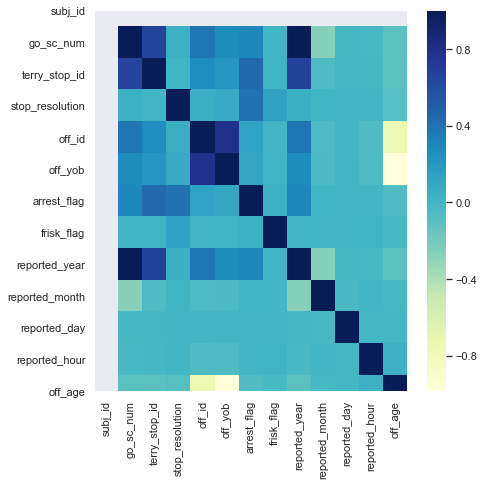

In [539]:
# View correlation between variables 
fig, ax = plt.subplots(figsize=(7,7))
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [540]:
# Pick features
features_df = cat_df.filter(['call_type_1',
                             'call_type_0',
                             'weapon_Blade',
                             'beat_M',
                             'beat_U',
                             'beat_K',
                             'beat_E',
                             'beat_F',
                             'off_race_White',
                             'subj_perceived_race_White',
                             'subj_perceived_race_Black or African American',
                             'off_age',
                             'date'], axis=1)

In [541]:
# View % distribution in target
cat_df.stop_resolution.value_counts(normalize=True)

0    0.75899
1    0.24101
Name: stop_resolution, dtype: float64

The above means 76% of the time a stop resolution does not lead to an arrest and 24% of the time it does.

In [542]:
# Check target is binary
dummies_df.stop_resolution.unique()

array([1, 0])

In [543]:
# Split training & testing data
y = dummies_df['stop_resolution']
X = dummies_df.drop(['stop_resolution'], axis=1)
X = features_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

#### Dummy Classifier
DummyClassifier is used below to make predictions using simple rules. This classifier is useful as a baseline to compare with other (real) classifiers.

In [629]:
# Load dummy classifier
dc = DummyClassifier()

In [630]:
# Fit on training data 
dc.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [631]:
# Make predictions 
dummy_pred = dc.predict(X_test)

##### Dummy Scores

In [632]:
# Scores
print(precision_score(y_test, dummy_pred))
print(f1_score(y_test, dummy_pred))
print(accuracy_score(y_test, dummy_pred))
print(recall_score(y_test, dummy_pred))

0.2430448222565688
0.24210931485758275
0.6324435318275154
0.24118098159509202


#### Grid Search CV

Combinatorial grid search is used below to find the best combination of parameters to improve model performance. Grid search performs an exhaustive search of every single combination from which to select the best parameters. Since Gridsearch is a computationally expensive task, it is set up with n_jobs = -1 to run things in parallel across all cores in the computer.

In [633]:
# Random forest parameter grid
rfc_param_grid_unbalanced = {
    'n_estimators': [350, 400, 450],
    'min_impurity_decrease': [.0001,.00001],
    'max_depth': [30, 40, 50]
}

In [634]:
# Random forest parameter grid
rfc_param_grid_balanced = {
    'class_weight': ['balanced','balanced_subsample'],
    'n_estimators': [350, 400, 450],
    'min_impurity_decrease': [.0001,.00001],
    'max_depth': [30, 40, 50]
}

In [635]:
# Logistic regression parameter grid
log_param_grid_unbalanced = { 
    'fit_intercept': ['True', 'False'],
    'intercept_scaling': [1,.01,.001,.0001],
    'C': [1,0.01,0.1,0.0001],
    'tol': [0.01,0.001,0.0001],
    'max_iter': [50,100,150,200]
}

In [636]:
# Logistic regression parameter grid
log_param_grid_balanced = { 
    'class_weight': ['balanced'],
    'fit_intercept': ['True', 'False'],
    'intercept_scaling': [1,.01,.001,.0001],
    'C': [1,0.01,0.1,0.0001],
    'tol': [0.01,0.001,0.0001],
    'max_iter': [50,100,150,200]
}

#### SMOTE

SMOTE is used below to address class imbalance problems in our data. As we see from the target (stop_resolution) count, arrests are the minority. Synthetic Minority Oversampling generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases.

It is worth noting here that SMOTE can be controvercial when working with a dataset on real people. There are ethical concerns when creating synthetic data representing people because the synthetics can amplify existing bias in the historical data. 

In [637]:
# SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=23)
X_train_SMOTE, y_train_SMOTE = smote.fit_sample(X_train, y_train)

# Random Forest Classifier

The Random Forest Classifier is an ensemble of decision trees that are trained to use bagging, or a combination of learning models, to obtain a more accurate and stable prediction. RFC is effective because of its randomness; instead of searching for the most important feature while building a tree, it searches for the best feature among a random subset of features only. When a a random subset of the features is taken into account when spliting a node, the model is able to more effectively find the features that are the most important in yielding an accurate outcome. RFC allows you to measure a feature's importance by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest.

#### RFC SMOTE

In [638]:
# Establish rfc with gridsearch where class weight is imbalanced
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, rfc_param_grid_unbalanced, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

# Fit Random Forest Classifier on data
grid_rfc.fit(X_train_SMOTE,y_train_SMOTE)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [639]:
# Predict on the test set
y_pred_grid=grid_rfc.best_estimator_.predict(X_test)

##### RFC SMOTE Scores

In [640]:
# Compare predictions to actuals to generate scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3385975994946305
F1: 0.4796420581655481
Acc: 0.5658017547134591
Rec: 0.8220858895705522


#### RFC Imbalanced Weight

In [641]:
# Establish rfc with gridsearch where class weight is imbalanced
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, rfc_param_grid_unbalanced, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

In [642]:
# Fit Random Forest Classifier on data
grid_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   34.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [643]:
# Print best parameters and estimator
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

{'max_depth': 40, 'min_impurity_decrease': 1e-05, 'n_estimators': 450}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [644]:
# Predict on the test set
y_pred_grid=grid_rfc.best_estimator_.predict(X_test)

##### RFC Imbalanced Weight Scores

In [645]:
# Scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.5454545454545454
F1: 0.05255474452554745
Acc: 0.757700205338809
Rec: 0.027607361963190184


In [646]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[8046   60]
 [2536   72]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      8106
           1       0.55      0.03      0.05      2608

    accuracy                           0.76     10714
   macro avg       0.65      0.51      0.46     10714
weighted avg       0.71      0.76      0.66     10714



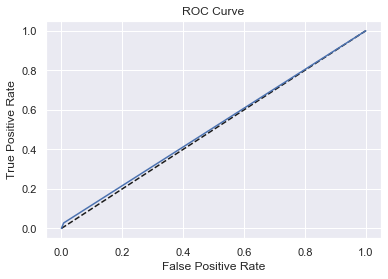

In [647]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

#### RFC Balanced Weight

Since we know that our target is imbalanced (an arrest only happens 24% of the time), we can make the classifier aware of the imbalanced data by incorporating the weights of the classes into the cost function, by using the utility function class_weight = 'balanced'. Intuitively, we want to give higher weight to the minority class (an arrest) and lower weight to the majority class (non-arrest). 

In [648]:
# Establish rfc with gridsearch where class weight is balanced
rfc = RandomForestClassifier(class_weight='balanced')
grid_rfc = GridSearchCV(rfc, rfc_param_grid_balanced, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

In [649]:
# Fit Random Forest Classifier on data
grid_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [650]:
#  Print best parameters and estimator
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

{'class_weight': 'balanced_subsample', 'max_depth': 30, 'min_impurity_decrease': 1e-05, 'n_estimators': 450}
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=1e-05,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=450, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [651]:
# Predict on the test set
y_pred_grid=grid_rfc.best_estimator_.predict(X_test)

##### RFC Balanced Weight Scores

In [652]:
# Get F1, accuracy, precision, and recall scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3443526170798898
F1: 0.4841098074951588
Acc: 0.5772820608549561
Rec: 0.8148006134969326


In [653]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4060 4046]
 [ 483 2125]]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      8106
           1       0.34      0.81      0.48      2608

    accuracy                           0.58     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.58      0.60     10714



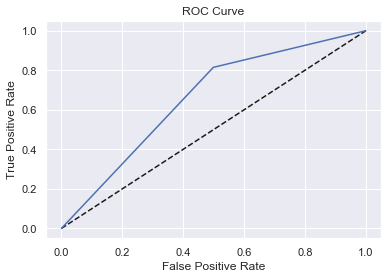

In [654]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

#### RFC with Undersampling

Another commonly used techniques to deal class imbalance is data resampling by either under-sampling the majority class, or oversampling the minority class of the training data. In this case, I will undersample the majority class (class 0, or when the stop does not lead to an arrest).

In [655]:
# Pull the target from training data
X_train['stop_resolution'] = y_train

# View shape
print(y.shape)
print(X.shape)

(42853,)
(42853, 12)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [656]:
# Minority is 7720 and majority is 24419
X_train['stop_resolution'].value_counts()

0    24419
1     7720
Name: stop_resolution, dtype: int64

In [657]:
# Set sample to class 0 majority
class0 = X_train[X_train['stop_resolution']==0].sample(n=7720, replace=True)
# Check count
class0.shape

(7720, 13)

In [658]:
# Set class1 
class1 = X_train[X_train['stop_resolution']==1]
# Check count of class 0 == class 1 
class1.shape

(7720, 13)

In [659]:
# Combine training dataset only, for both 0 + 1s
X_train_undersample = pd.concat([class0,class1])

In [660]:
# Check value counts are the same for both 
X_train_undersample['stop_resolution'].value_counts()

1    7720
0    7720
Name: stop_resolution, dtype: int64

In [661]:
# Confirm concatenation with shape
print(X_train_undersample.shape)
print(y_train_undersample.shape)

(15440, 13)
(15440,)


In [662]:
# Pull target variable
y_train_undersample = X_train_undersample['stop_resolution']
# Check shape
y_train_undersample.shape

(15440,)

In [663]:
# Drop target column from training features 
X_train_undersample.drop('stop_resolution', inplace = True, axis = 1)

In [664]:
# Establish rfc with gridsearch
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, rfc_param_grid_unbalanced, cv = 3, n_jobs = -1, scoring = 'precision', verbose = 1)

In [665]:
# Fit Random Forest Classifier on data
grid_rfc.fit(X_train_undersample,y_train_undersample)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   18.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [666]:
# Print best parameters and estimator
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

{'max_depth': 50, 'min_impurity_decrease': 1e-05, 'n_estimators': 450}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [667]:
# Predict on the test set
y_pred_undersample=grid_rfc.best_estimator_.predict(X_test)

##### RFC with Undersampling Scores

In [668]:
# Scores
print("Prec:",metrics.precision_score(y_test, y_pred_undersample))
print("F1:",metrics.f1_score(y_test, y_pred_undersample))

print("Acc:",metrics.accuracy_score(y_test, y_pred_undersample))
print("Rec:",metrics.recall_score(y_test, y_pred_undersample))

Prec: 0.33845437616387336
F1: 0.4818824569155988
Acc: 0.5622549934664924
Rec: 0.8362730061349694


#### Feature Importance
Feature selection is an important step in model tuning because it reduces dimensionality which improves the model speed and performance.

In [669]:
# List of features in order of importance
feat_importances = pd.Series(grid_rfc.best_estimator_.feature_importances_, index=X.columns)
df_feat_importances = pd.DataFrame(feat_importances)
df_feat_importances.sort_values(by=[0], ascending=False)

,0
call_type_0,0.311027
off_age,0.286474
call_type_1,0.189698
beat_M,0.043419
weapon_Blade,0.039297
beat_E,0.027412
beat_K,0.022386
off_race_White,0.022251
subj_perceived_race_Black or African American,0.017906
subj_perceived_race_White,0.017463


Overall, the most important features appear to be when the officer was called to the location (via 911, text etc.), if the location was in a high-crime beat, if the subject had a blade as a weapon, if the officer or subject race was white or if the subject race was black. These features will be used in classification models to predict whether a stop will result in an arrest or not (where stop_resolution = 1 for arrest and 0 for all others).

# Logistic Regression

Logistic regression predicts categorical (binomial/multinomial) outcomes in the form of probabilities by using  a cross-entropy cost function known as Log Loss. Logarithmic loss measures the performance of a classification model where probability ranges between 0 and 1. Log loss increases as the predicted probability diverges from the actual. Therefore, the goal of our logarithmic regression model is to minimize the log loss and hence approach 1 for the predicted probability, wherein the prediction is as close to the actual value as possible.

#### LR SMOTE

In [670]:
# Fit logistic regression on data balanced with SMOTE
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train_SMOTE,y_train_SMOTE)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [671]:
# Predict on testing data
y_pred_base = logreg.predict(X_test)

##### LR SMOTE Scores

In [672]:
# Compare predictions to actuals to generate scores
print("Prec:",metrics.precision_score(y_test, y_pred_base))
print("F1:",metrics.f1_score(y_test, y_pred_base))

print("Acc:",metrics.accuracy_score(y_test, y_pred_base))
print("Rec:",metrics.recall_score(y_test, y_pred_base))

Prec: 0.33143191458241916
F1: 0.4798305982001058
Acc: 0.5414411050961359
Rec: 0.8688650306748467


In [673]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred_base))
# Classification report
print(classification_report(y_test, y_pred_base))

[[3535 4571]
 [ 342 2266]]
              precision    recall  f1-score   support

           0       0.91      0.44      0.59      8106
           1       0.33      0.87      0.48      2608

    accuracy                           0.54     10714
   macro avg       0.62      0.65      0.53     10714
weighted avg       0.77      0.54      0.56     10714



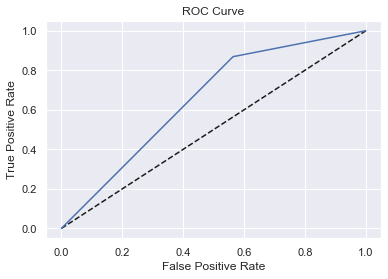

In [674]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [675]:
# Calculate null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.7565801754713459

The above indicates that a dumb model that always predicts 0 would be right 76% of the time. This provides a minimum to achieve with the model.

#### LR Imbalanced Weight

In [676]:
# Split training & testing data
y = dummies_df['stop_resolution']
X = dummies_df.drop(['stop_resolution'], axis=1)
X = features_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [677]:
# Set LR up using gridsearch
logreg = LogisticRegression(multi_class='ovr', solver = 'liblinear')
grid_logreg = GridSearchCV(logreg, log_param_grid_unbalanced, cv=3, scoring='f1', verbose=1, n_jobs=-1)
# Fit LR
grid_logreg.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   17.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 0.01, 0.1, 0.0001],
                         'fit_intercept': ['True', 'False'],
                         'intercept_scaling': [1, 0.01, 0.001, 0.0001],
                         'max_iter': [50, 100, 150, 200],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', re

In [678]:
# Print best parameters and estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'fit_intercept': 'True', 'intercept_scaling': 0.001, 'max_iter': 50, 'tol': 0.0001}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept='True',
                   intercept_scaling=0.001, l1_ratio=None, max_iter=50,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [679]:
# Predict on testing data
y_pred_base = grid_logreg.predict(X_test)

In [680]:
# Predict on the test set
logreg_y_pred_grid=grid_logreg.best_estimator_.predict(X_test)

In [681]:
# Best parameters and best estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'fit_intercept': 'True', 'intercept_scaling': 0.001, 'max_iter': 50, 'tol': 0.0001}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept='True',
                   intercept_scaling=0.001, l1_ratio=None, max_iter=50,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


##### LR Imbalanced Weight Scores

In [682]:
# Print scores
print("Prec:",metrics.precision_score(y_test, y_pred_grid))
print("F1:",metrics.f1_score(y_test, y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, y_pred_grid))
print("Rec:",metrics.recall_score(y_test, y_pred_grid))

Prec: 0.3443526170798898
F1: 0.4841098074951588
Acc: 0.5772820608549561
Rec: 0.8148006134969326


In [683]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4060 4046]
 [ 483 2125]]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      8106
           1       0.34      0.81      0.48      2608

    accuracy                           0.58     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.58      0.60     10714



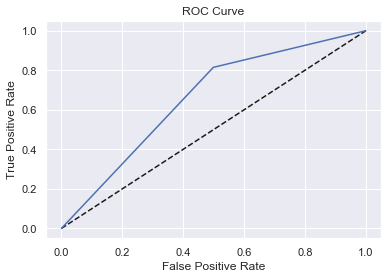

In [684]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [685]:
# Get coefficients
import statsmodels.api as sm
model = sm.Logit(cat_df.stop_resolution, cat_df[['call_type_1',
                             'call_type_0',
                             'weapon_Blade',
                             'beat_M',
                             'beat_U',
                             'beat_K',
                             'beat_E',
                             'beat_F',
                             'off_race_White',
                             'subj_perceived_race_White',
                             'subj_perceived_race_Black or African American',
                             'off_age']])
                            


In [686]:
# Get results
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.510079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        stop_resolution   No. Observations:                42853
Model:                          Logit   Df Residuals:                    42841
Method:                           MLE   Df Model:                           11
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 0.07635
Time:                        19:26:07   Log-Likelihood:                -21858.
converged:                       True   LL-Null:                       -23665.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
call_type_1                                       1.4082      0.038     36.863      0.000       1.333       1.483
call_type_0                                       1.4204      0.032     44.510      0.000       1.358       1.483
weapon_Blade                                      0.8020      0.051     15.646      0.000       0.702       0.903
beat_M                                            0.4289      0.042     10.235      0.000       0.347       0.511
beat_U                                           -0.1693      0.064     -2.658      0.008      -0.294      -0.044
beat_K                                            0.1107      0.044      2.543      0.011       0.025       0.196
beat_E                                            0.1912      0.042      4.516      0.000       0.108       0.274
beat_F                                           -0.1609      0.059     -2.724      0.006      -0.277      -0.045
off_race_White                                   -0.1805      0.027     -6.808      0.000      -0.232      -0.129
subj_perceived_race_White                        -0.2301      0.029     -7.967      0.000      -0.287      -0.174
subj_perceived_race_Black or African American    -0.0851      0.031     -2.729      0.006      -0.146      -0.024
off_age                                          -0.0594      0.001    -57.926      0.000      -0.061      -0.057
=================================================================================================================
"""

#### LR Balanced Weight

In [687]:
# Fit Logistic Regression
logreg = LogisticRegression(multi_class='ovr', solver = 'liblinear', class_weight = 'balanced')
grid_logreg = GridSearchCV(logreg, log_param_grid_balanced, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   15.5s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 0.01, 0.1, 0.0001],
                         'class_weight': ['balanced'],
                         'fit_intercept': ['True', 'False'],
                         'intercept_scaling': [1, 0.01, 0.001, 0.0001],
                         'max_iter': [50, 100, 150, 200],
                         'tol': [0.

In [688]:
# Predict on the test set
log_y_pred_grid=grid_logreg.best_estimator_.predict(X_test)

In [689]:
# Best parameters and best estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'class_weight': 'balanced', 'fit_intercept': 'True', 'intercept_scaling': 1, 'max_iter': 50, 'tol': 0.001}
LogisticRegression(C=1, class_weight='balanced', dual=False,
                   fit_intercept='True', intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)


##### LR Balanced Weight Scores

In [690]:
# Print scores
print("Prec:",metrics.precision_score(y_test, log_y_pred_grid))
print("F1:",metrics.f1_score(y_test, log_y_pred_grid))

print("Acc:",metrics.accuracy_score(y_test, log_y_pred_grid))
print("Rec:",metrics.recall_score(y_test, log_y_pred_grid))

Prec: 0.33274414494034465
F1: 0.48079174204533354
Acc: 0.5446145230539481
Rec: 0.866180981595092


In [691]:
# Get results
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.510079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        stop_resolution   No. Observations:                42853
Model:                          Logit   Df Residuals:                    42841
Method:                           MLE   Df Model:                           11
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 0.07635
Time:                        19:26:23   Log-Likelihood:                -21858.
converged:                       True   LL-Null:                       -23665.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
call_type_1                                       1.4082      0.038     36.863      0.000       1.333       1.483
call_type_0                                       1.4204      0.032     44.510      0.000       1.358       1.483
weapon_Blade                                      0.8020      0.051     15.646      0.000       0.702       0.903
beat_M                                            0.4289      0.042     10.235      0.000       0.347       0.511
beat_U                                           -0.1693      0.064     -2.658      0.008      -0.294      -0.044
beat_K                                            0.1107      0.044      2.543      0.011       0.025       0.196
beat_E                                            0.1912      0.042      4.516      0.000       0.108       0.274
beat_F                                           -0.1609      0.059     -2.724      0.006      -0.277      -0.045
off_race_White                                   -0.1805      0.027     -6.808      0.000      -0.232      -0.129
subj_perceived_race_White                        -0.2301      0.029     -7.967      0.000      -0.287      -0.174
subj_perceived_race_Black or African American    -0.0851      0.031     -2.729      0.006      -0.146      -0.024
off_age                                          -0.0594      0.001    -57.926      0.000      -0.061      -0.057
=================================================================================================================
"""

In [692]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

[[4060 4046]
 [ 483 2125]]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      8106
           1       0.34      0.81      0.48      2608

    accuracy                           0.58     10714
   macro avg       0.62      0.66      0.56     10714
weighted avg       0.76      0.58      0.60     10714



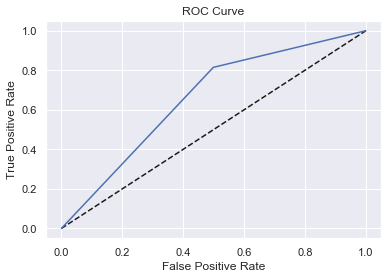

In [693]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grid)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

#### LR with Undersampling

In [694]:
# Fit LR
logreg = LogisticRegression(multi_class='ovr', solver = 'liblinear')
grid_logreg = GridSearchCV(logreg, log_param_grid_unbalanced, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train_undersample,y_train_undersample)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:    4.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 0.01, 0.1, 0.0001],
                         'fit_intercept': ['True', 'False'],
                         'intercept_scaling': [1, 0.01, 0.001, 0.0001],
                         'max_iter': [50, 100, 150, 200],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', re

In [695]:
# Predict on the test set
log_y_pred_undersample=grid_logreg.best_estimator_.predict(X_test)

In [696]:
# Best parameters and best estimator
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)

{'C': 1, 'fit_intercept': 'True', 'intercept_scaling': 1, 'max_iter': 50, 'tol': 0.001}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept='True',
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)


##### LR with Undersampling Scores

In [697]:
# Print Scores
print("Prec:",metrics.precision_score(y_test, y_pred_undersample))
print("F1:",metrics.f1_score(y_test, y_pred_undersample))

print("Acc:",metrics.accuracy_score(y_test, y_pred_undersample))
print("Rec:",metrics.recall_score(y_test, y_pred_undersample))

Prec: 0.33845437616387336
F1: 0.4818824569155988
Acc: 0.5622549934664924
Rec: 0.8362730061349694


# Classification Result Summary

Here is a summary of the precision and F1 scores (designated as the most important in context of this data):
    
- Dummy Baseline:

Precision: .24   
F1: .24

- RFC SMOTE:

Precision: .34  
F1: .48

- RFC Imbalanced:

Precision: .55  
F1: .05

- RFC Balanced:

Precision: .34   
F1: .48

- RFC Undersampling:

Precision: .34   
F1: .48


- Logistic Regression SMOTE:

Precision: .33  
F1: .48

- Logistic Regression Imbalanced:

Precision: .55   
F1: .05

- Logistic Regression Balanced:

Precision: .33   
F1: .48

- Logistic Regression Undersampling:

Precision: .34  
F1: .48



The model with the highest overall scores was the balanced Random Forest.

Compared to a dummy baseline, the balanced and undersampled RFC and LR were about 10% more precise and had a 24% better F1 score.

Balancing class weight improved precision by 31%.

Overall, the most predictive features were when:
- officer was called to the location (via 911, text etc.)
- location was in a high-crime beat
- subject had a blade 
- officer or subject race was white 
- subject race was black

The prediction metrics of the algorithms were not significantly predictive. However, the exploratory data analysis provided insight into stark disparities of stops according to race.

# Ideas for Future Exploration
- Exploratory data analysis showed an over-representation of Black, Hispanic and Native American frisks and arrests relative to the population. It would be interesting to evaluate the impact of skin color, rather than race, on stop resolutions. For example, if one were to compare two groups (i.e. Native American, Hispanic & Black to Asian & White) whether feature importance would change and those features would have a more significant impact on the classification model in predicting arrest. Another option would be to evaluate the impact of White versus non-White on the model.
- A cluster analysis could investigate whether there are groups of officers that stop certain subjects. Likewise,  one could isolate whether there are outlier officers whose historical arrests are out of the norm for a specific area.
- A time series approach could identify stops or frisks of a class of subjects during certain times of day.